<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/master/Lab_5_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression

In this lab we will finally start running models! For this we will use the excellent [```scikit-learn```](https://scikit-learn.org/stable/) package, which implements many, many data science methods. This is the go-to tool for any structured data analysis package.

First, we will import the data from last week. For this we will upload the files. I left the two train and test files in Blackboard, download them and we will import them to our workspace. To open an upload dialog we use the ```files.upload command``` from Google's ```file``` package. 

In [0]:
from google.colab import files
files.upload()

Saving test_woe.csv to test_woe.csv
Saving train_woe.csv to train_woe.csv


{'test_woe.csv': b'Default,MonthlyLoad_woe,Address_woe,Leverage_woe,Creddebt_woe,Employ_woe,Age_woe\n0,-0.6202249144816572,-0.5693852377022479,-0.8570673101540289,0.19344901777412474,-3.1120736261649395,-0.25990017656647374\n0,-0.6202249144816572,0.9534876266940643,-0.8570673101540289,-0.29090926297868797,0.8518044992682585,0.8214784096903723\n0,-0.6202249144816572,-2.228094199143131,-0.09314313631363064,0.19344901777412474,-3.1120736261649395,-1.9179392708392915\n1,-0.6202249144816572,0.5783478483008121,-0.09314313631363064,0.19344901777412474,0.30758477601829265,0.8214784096903723\n0,0.4227975881191306,0.04320291888012119,-0.09314313631363064,-0.29090926297868797,-0.41614669406668425,0.33831607895808075\n0,-1.435672948981762,-0.5693852377022479,-0.8570673101540289,-0.29090926297868797,-0.41614669406668425,-0.25990017656647374\n1,-0.6202249144816572,0.9534876266940643,-0.8570673101540289,-0.29090926297868797,0.8518044992682585,0.8214784096903723\n1,-0.6202249144816572,-0.5693852377022

In [0]:
!ls

sample_data  test_woe.csv  train_woe.csv


Now the data is ready to import. We can read the CSV files directly.

In [0]:
import pandas as pd
import numpy as np

train_woe = pd.read_csv("train_woe.csv")
test_woe = pd.read_csv("test_woe.csv")

In [0]:
train_woe.describe()

,Default,MonthlyLoad_woe,Address_woe,Leverage_woe,Creddebt_woe,Employ_woe,Age_woe
count,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000,1026.000000
mean,0.363548,-0.081281,-0.085800,-0.052083,-0.012528,-0.221405,-0.120007
std,0.481255,0.850240,0.754560,0.744740,0.357626,1.175562,0.855472
min,0.000000,-1.435673,-2.228094,-0.857067,-0.290909,-3.112074,-1.917939
25%,0.000000,-0.620225,-0.569385,-0.857067,-0.290909,-0.416147,-0.259900
50%,0.000000,-0.620225,0.043203,-0.093143,-0.290909,0.307585,-0.259900
75%,1.000000,0.422798,0.043203,-0.093143,0.193449,0.851804,0.338316
max,1.000000,1.487339,0.953488,1.400782,0.965464,0.851804,0.821478


## Generating a logistic regression object

To train a logistic regression, we first need to create an object that stores how we want the model to be trained. In general, all of scikit-learn models work this way:

- We create the model we want to train, with all required parameters. This model is **not trained yet**, it just keeps the logic we will use.

- We apply the ```fit``` function to the object we just created. This takes as input the training set and the targets (if the model is supervised), and will update our model with trained parameters.

- We then used our trained model to apply it to a test set, and calculate outputs. 

Logistic regression is included in the [```linear_model subpackage```](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) and it comes pre-packaged with two very powerful variable selection algorithms: the LASSO penalization and the Ridge penalization (refer to the lectures for the explanation of these, or read this [excellent tutorial](https://codingstartups.com/practical-machine-learning-ridge-regression-vs-lasso/)).

In a nutshell, LASSO and Ridge are going to penalize including variables by adding either a linear (LASSO) or quadratic (Ridge) term to the minimization algorithm. This way the model with try to eliminate variables at the same time as maximizing the predictive capability, thus mitigating overfitting. It is a good idea to use it.

Let's start by creating the logistic regression object.




In [0]:
from sklearn.linear_model import LogisticRegression

bankloan_logreg = LogisticRegression(penalty='l1', # Type of penalization l1 = lasso, l2 = ridge
                                     tol=0.0001, # Tolerance for parameters
                                     C=1.0, # Penalty constant, see below
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     random_state=20190301, # Random seed
                                     max_iter=100, # Maximum iterations
                                     verbose=1, # Show process. 1 is yes.
                                     solver = 'saga',
                                     warm_start=False # Train anew or start from previous weights. For repeated training. 
                                    )

Let's dig deeper into what is needed.

**Penalty**

'l1' penalty refers to LASSO regression (more strict), and 'l2' to Ridge regression (less strict, but easiear to solve). My advice: Start with LASSO, if it doesn't work or you are not happy with the results, move to Ridge. Large problems (over 10 million points) might require the use of Ridge regression in home computers.

**Penalty constant**

This refers to how much to weight the error in prediction versus the regularization (penalty) error. When optimizing the parameters, a penalization constant will try to optimise the following:

$$
Error = Error_{prediction} + C \times Error_{penalty}
$$

So the $$C$$ constant will balance both objectives. This is a tunable parameter, meaning we need to search for what leaves us happy. In general, if you think the model is being too strict, then reduce C; if it is being too lax, increase it.

**Class weighting**

Most interesting problems are unbalanced. This means the interesting class (Default in our case) has less cases than the opposite class. Models optimise the sum over **all** cases, so if we minimize the error, which class do you think will be better classified?

This means we need to balance the classes to make them equal. Luckily for us, Scikit-Learn includes automatic weighting that assigns the same error to both classes. The error becomes the following:

$$
Error = Weight_1 \times Error_{predictionClass1} + Weight_2 \times Error_{predictionClass2} + C \times Error_{penalty}
$$

The weights are selected so the theoretical maximum error in both classes is the same (see the help for the exact equation).

**Random State**

The random seed. Remember to use your student ID.

**Iterations**

The solution comes from an iterative model, thus we specify a maximum number of iterations. Remember to check for convergence after it has been solved!

**Solver**

Data science functions are complex ones, with thousands, millions, or even billions of parameters. Thus we need to use the best possible solver for our problems. Several are implemented in scikit-learn. The help states that:


- For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
- For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
- ‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.

We will use 'saga', a very efficient solver. You can read all about it [here](https://www.di.ens.fr/~fbach/Defazio_NIPS2014.pdf).


**Warm start**

Scikit-learn allows for multiple adjustments to the training. For example, you can try first with a little bit of data just to check if everything is working, and then, if you set ```warm_start = True``` before, it will retrain starting from the original parameters. Allows for dynamic updating as well.  ```warm_start = False``` means whenever we give it new data, it will start from scratch, forgetting what it previously learned.

## Training!

Now we are ready to train. We simply apply the method ```fit``` to our data, giving it the training set and the target variable as inputs.

In [0]:
bankloan_logreg.fit(X = train_woe.iloc[:, 1:], # All rows and from the second var to end
                    y = train_woe['Default'] # The target
                   )

convergence after 14 epochs took 0 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1',
          random_state=20190301, solver='saga', tol=0.0001, verbose=1,
          warm_start=False)

Let's read the output:

```convergence after 14 epochs took 0 seconds```

The method was able to find a solution at the given tolerance, and it took 14 iterations and almost no time. **If the method says it did not converge then you need to increase iterations, change C or both!**.

The rest of the output refers to what it did, it is not relevant at this stage.

Done! We have a logistic regression! Let's check the parameters, sorted into a nice table. 


In [0]:
coef_df = pd.concat([pd.DataFrame({'column': train_woe.columns[1:]}), 
                    pd.DataFrame(np.transpose(bankloan_logreg.coef_))],
                    axis = 1
                   )

coef_df

,column,0
0,MonthlyLoad_woe,0.297566
1,Address_woe,0.000000
2,Leverage_woe,0.730185
3,Creddebt_woe,1.807094
4,Employ_woe,1.113436
5,Age_woe,0.619124


We can see the parameter for each variable now. This does not include the constant. We can get it with

In [0]:
bankloan_logreg.intercept_

array([-0.00956024])

We can see the variable address was not being used, and the intercept is really close to 0. This is expected in a balanced logistic regression that uses WoE transform and is a way to check everything is working as intended.

## Applying to the test set

We can now apply our results to the test set, and check our results. Most models in scikit-learn have the ```predict``` method which applies the model to new data, this gives the 0-1 prediction. Alternatively (and more usefully) we can use the ```predict_proba``` method that gives the probability.

In [0]:
pred_class_test = bankloan_logreg.predict(test_woe.iloc[:, 1:])
probs_test = bankloan_logreg.predict_proba(test_woe.iloc[:, 1:])
print(probs_test, pred_class_test)

[[0.98363903 0.01636097]
 [0.47218111 0.52781889]
 [0.98969825 0.01030175]
 [0.28119861 0.71880139]
 [0.67510255 0.32489745]
 [0.9013708  0.0986292 ]
 [0.47218111 0.52781889]
 [0.76207166 0.23792834]
 [0.68862541 0.31137459]
 [0.0864819  0.9135181 ]
 [0.68862541 0.31137459]
 [0.0500929  0.9499071 ]
 [0.27297812 0.72702188]
 [0.21478223 0.78521777]
 [0.80409592 0.19590408]
 [0.87760033 0.12239967]
 [0.97176507 0.02823493]
 [0.63107063 0.36892937]
 [0.99249804 0.00750196]
 [0.29769661 0.70230339]
 [0.70198893 0.29801107]
 [0.22590762 0.77409238]
 [0.95968895 0.04031105]
 [0.0311982  0.9688018 ]
 [0.34016104 0.65983896]
 [0.14003645 0.85996355]
 [0.98711866 0.01288134]
 [0.55637044 0.44362956]
 [0.95241268 0.04758732]
 [0.36715922 0.63284078]
 [0.60596839 0.39403161]
 [0.99568085 0.00431915]
 [0.9013708  0.0986292 ]
 [0.82683282 0.17316718]
 [0.63107063 0.36892937]
 [0.13530495 0.86469505]
 [0.6021864  0.3978136 ]
 [0.99311596 0.00688404]
 [0.33616593 0.66383407]
 [0.73918235 0.26081765]


Scikit-learn will give, by default, one probability per class.  The second column is the one that applies for class Default = 1.

We will get the AUC and the confusion matrix. These are included in the subpackage ```sklearn.metrics```

In [0]:
from sklearn.metrics import roc_auc_score, confusion_matrix

In [0]:
confusion_matrix(y_true = test_woe['Default'], y_pred = pred_class_test)

array([[197,  83],
       [ 43, 117]])

In [0]:
roc_auc_score(y_true = test_woe['Default'], y_score = probs_test[:,1])

0.7934486607142858

Pretty good model! We can also plot the ROC curve, but this takes a bit more work. We will import the raw ROC curve and plot it.

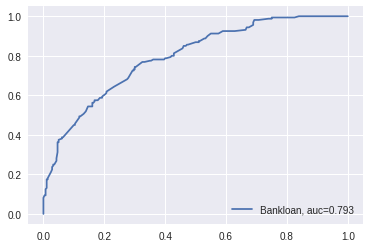

In [0]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_woe['Default'], probs_test[:,1])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_woe['Default'], 
                             y_score = probs_test[:,1]),
              decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Bankloan, auc="+str(auc))
plt.legend(loc=4)
plt.show()

That's it! Next lab we'll create a scorecard and compare it to a Random Forest and an XGBoost